In [50]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [51]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

with pd.HDFStore(DATA_STORE) as store:
    data = store['data/top500_dataset']

In [53]:
selected_data = data[['open', 'high', 'low', 'close', 'volume']]

In [54]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZION', Timestamp('2023-08-10 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1336327 non-null  float64
 1   high    1336327 non-null  float64
 2   low     1336327 non-null  float64
 3   close   1336327 non-null  float64
 4   volume  1336327 non-null  float64
dtypes: float64(5)
memory usage: 56.5+ MB


In [55]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

class FractionalDifferentiator:
    def __init__(self):
        pass

    def getWeights(self, d, size):
        w = [1.]
        for k in range(1, size):
            w_ = -w[-1] / k * (d - k + 1)
            w.append(w_)
        w = np.array(w[::-1]).reshape(-1, 1)
        return w

    def fracDiff(self, series, d, thres=0.01):
        w = self.getWeights(d, series.shape[0])
        w_ = np.cumsum(abs(w))
        w_ /= w_[-1]
        skip = w_[w_ > thres].shape[0]
        diff = []
        for name in series.columns:
            series_fi = series[[name]].fillna(method='ffill').dropna()
            df_ = pd.Series()
            for iloc in range(skip, series_fi.shape[0]):
                loc = series_fi.index[iloc]
                if not np.isfinite(series.loc[loc, name]):
                    continue
                df_[loc] = np.dot(w[-(iloc + 1):, :].T, series_fi.loc[:loc])[0, 0]
            diff.append(df_)
        return pd.concat(diff, axis=1)

    def FitTransform(self, X):
        d = 0.5  # you might need to adjust this parameter as needed
        return self.fracDiff(X, d)

def process_tickers(df):
    # Initialize the FractionalDifferentiator
    fracDiff = FractionalDifferentiator()
    
    # Function to process each group
    def process_group(group):
        group = group.copy()
        X_ticker = group[['close']]
        X_frac = fracDiff.FitTransform(X_ticker)
        if 'close' in X_frac.columns:
            group['ret_frac_diff'] = X_frac['close'].values
        return group

    # Apply the process_group function to each group
    result_df = df.groupby(level=0).apply(process_group)
    return result_df

# Assuming df is your DataFrame
df_with_frac_diff = process_tickers(selected_data)

IndexingError: Too many indexers

For ticker AA, estimated orders range from 0.2421875 to 0.2421875.


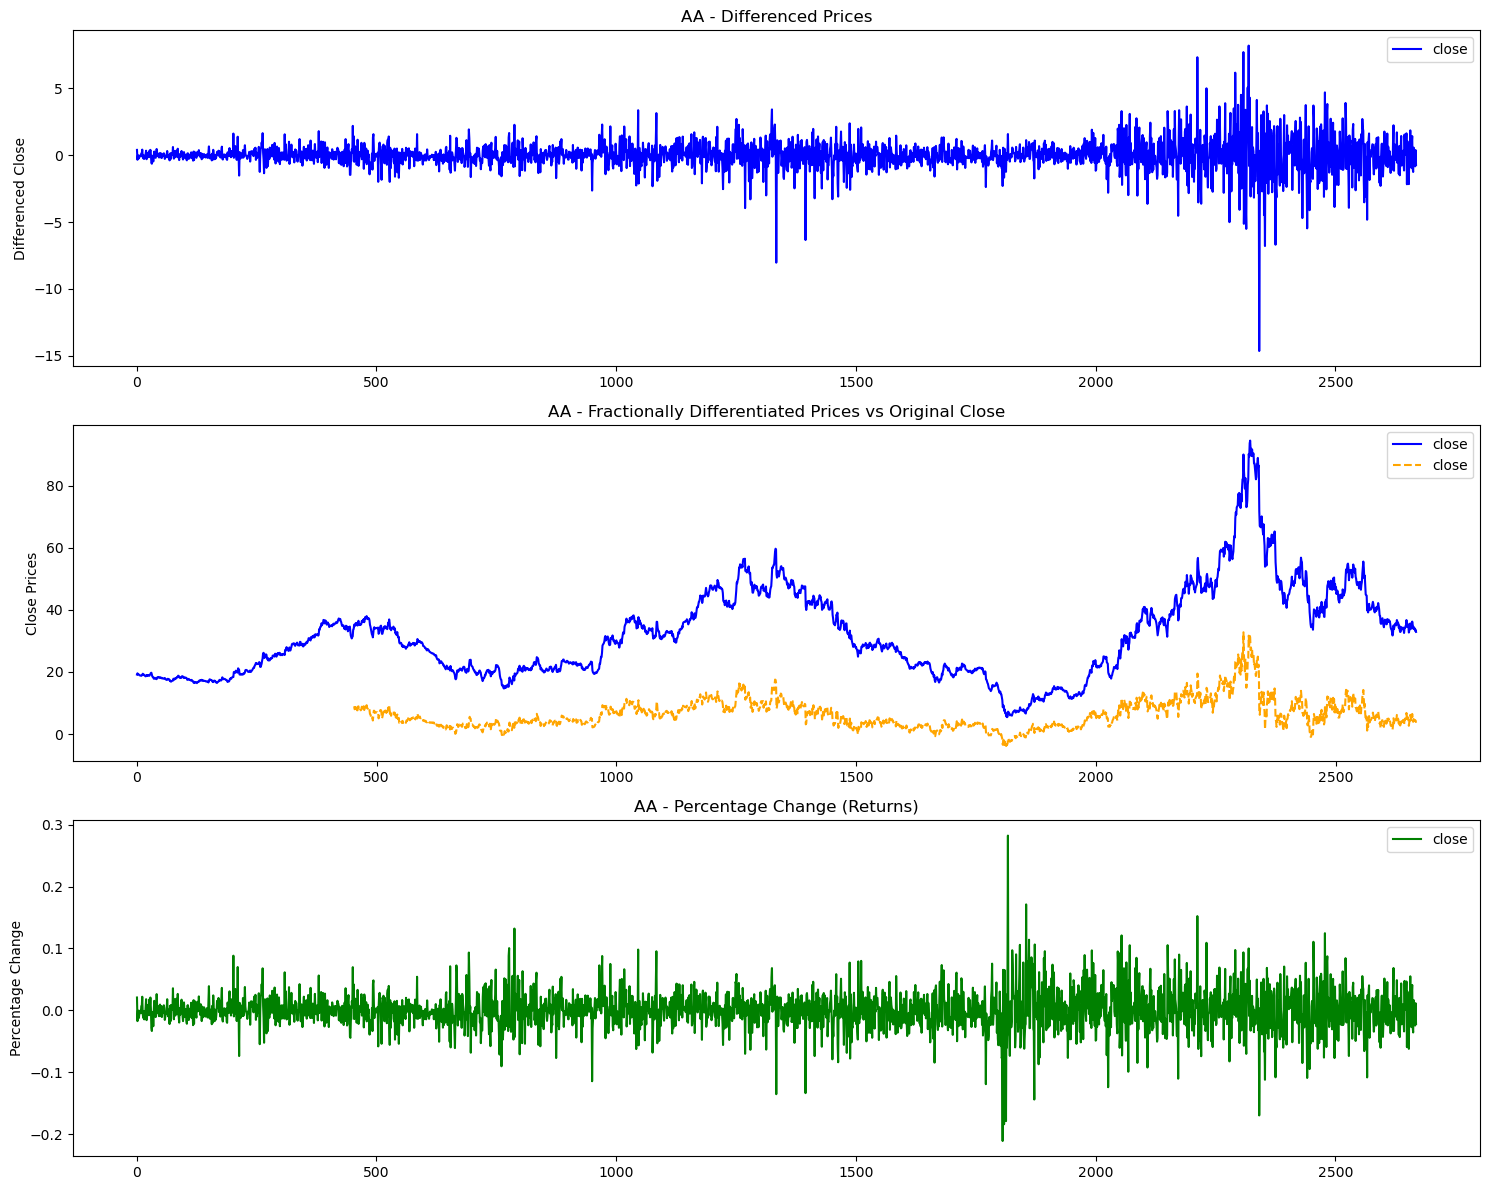

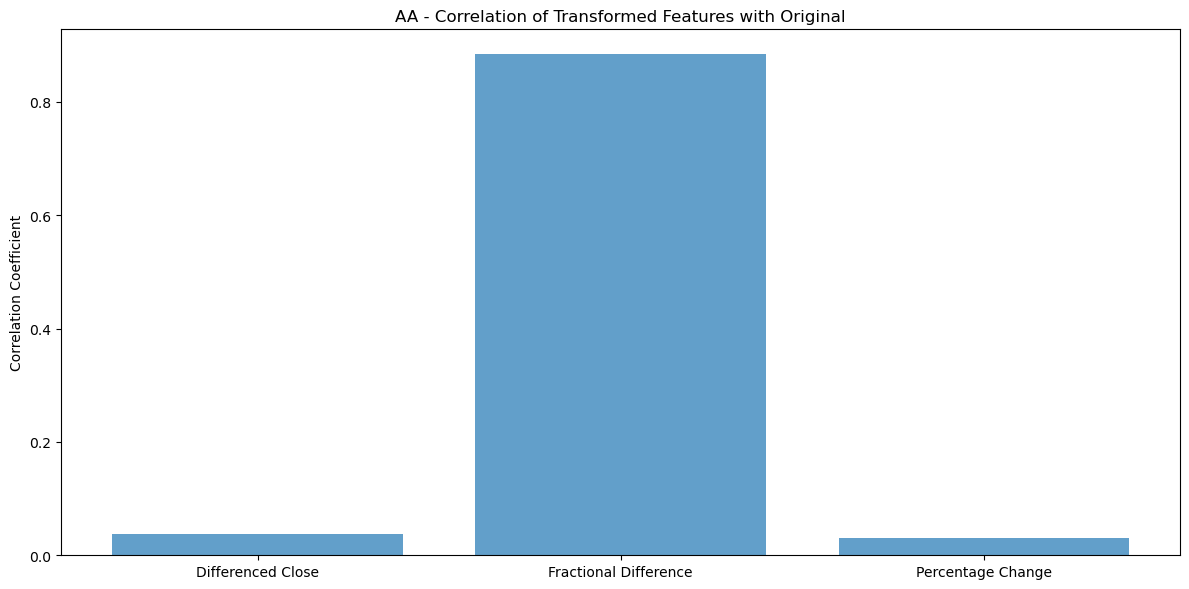

Across all tickers, estimated orders range from 0.2421875 to 0.2421875.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tsfracdiff import FractionalDifferentiator

def process_tickers(df):
    all_orders = []

    for ticker, group in df.groupby(level=0):
        group = group.reset_index(drop=True)  # Reset the multi-index for the current group

        # Focus on the 'close' prices
        X_ticker = group[['close']]

        # Calculate percentage change (returns)
        X_pct_change = X_ticker.pct_change().dropna()

        # 1. Fractional Differentiation for the specific ticker
        fracDiff = FractionalDifferentiator()
        X_frac = fracDiff.FitTransform(X_ticker)

        # Print estimated orders for the specific ticker
        orders = fracDiff.orders
        print(f"For ticker {ticker}, estimated orders range from {min(orders)} to {max(orders)}.")
        all_orders.extend(orders)

        # 2. First Difference
        X_diff = X_ticker.diff().dropna()

        # 3. Plotting
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        
        X_diff.plot(title=f'{ticker} - Differenced Prices', ax=axes[0], color='blue')
        axes[0].set_ylabel('Differenced Close')
        
        X_ticker.plot(ax=axes[1], label='Original Close', color='blue')
        X_frac.plot(title=f'{ticker} - Fractionally Differentiated Prices vs Original Close', ax=axes[1], linestyle='--', color='orange')
        axes[1].set_ylabel('Close Prices')
        axes[1].legend()
        
        X_pct_change.plot(title=f'{ticker} - Percentage Change (Returns)', ax=axes[2], color='green')
        axes[2].set_ylabel('Percentage Change')

        plt.tight_layout()
        plt.show()

        # 4. Plotting Correlations
        fig, ax = plt.subplots(figsize=(12, 6))
        correlations = {
            'Differenced Close': X_diff.corrwith(X_ticker)['close'],
            'Fractional Difference': X_frac.corrwith(X_ticker)['close'],
            'Percentage Change': X_pct_change.corrwith(X_ticker).iloc[0]
        }
        
        ax.bar(correlations.keys(), correlations.values(), alpha=0.7)
        ax.set_title(f'{ticker} - Correlation of Transformed Features with Original')
        ax.set_ylabel('Correlation Coefficient')
        plt.tight_layout()
        plt.show()
        break

    # Analyzing orders after processing all tickers
    print(f"Across all tickers, estimated orders range from {min(all_orders)} to {max(all_orders)}.")

# Assuming df is your DataFrame
process_tickers(selected_data)